# Influenza

In [6]:
import numpy as np
from scipy.integrate import odeint
import random
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('influenza.xlsx')
df

c:\Users\lebue\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Year,Epidemiological week,Influenza,Unnamed: 3,Year.1,Epidemiological week.1,Influenza.1,Unnamed: 7,Year.2,Epidemiological week.2,...,Epidemiological week.4,Influenza.4,Unnamed: 19,Year.5,Epidemiological week.5,Influenza.5,Unnamed: 23,Year.6,Epidemiological week.6,Influenza.6
0,2003,1,0,NaN,2004.0,1.0,2.0,NaN,2005.0,1.0,...,1.0,1.0,NaN,2008,1,0,NaN,2009.0,1.0,0.0
1,2003,2,0,NaN,2004.0,2.0,1.0,NaN,2005.0,2.0,...,2.0,2.0,NaN,2008,2,0,NaN,2009.0,2.0,0.0
2,2003,3,0,NaN,2004.0,3.0,0.0,NaN,2005.0,3.0,...,3.0,0.0,NaN,2008,3,6,NaN,2009.0,3.0,0.0
3,2003,4,0,NaN,2004.0,4.0,0.0,NaN,2005.0,4.0,...,4.0,1.0,NaN,2008,4,7,NaN,2009.0,4.0,0.0
4,2003,5,2,NaN,2004.0,5.0,0.0,NaN,2005.0,5.0,...,5.0,0.0,NaN,2008,5,3,NaN,2009.0,5.0,2.0
5,2003,6,0,NaN,2004.0,6.0,0.0,NaN,2005.0,6.0,...,6.0,3.0,NaN,2008,6,4,NaN,2009.0,6.0,2.0
6,2003,7,2,NaN,2004.0,7.0,0.0,NaN,2005.0,7.0,...,7.0,0.0,NaN,2008,7,0,NaN,2009.0,7.0,0.0
7,2003,8,1,NaN,2004.0,8.0,0.0,NaN,2005.0,8.0,...,8.0,3.0,NaN,2008,8,1,NaN,2009.0,8.0,1.0
8,2003,9,2,NaN,2004.0,9.0,0.0,NaN,2005.0,9.0,...,9.0,1.0,NaN,2008,9,0,NaN,2009.0,9.0,1.0
9,2003,10,2,NaN,2004.0,10.0,0.0,NaN,2005.0,10.0,...,10.0,0.0,NaN,2008,10,0,NaN,2009.0,10.0,1.0


In [7]:
# Identificar las columnas de influenza
influenza_columns = [col for col in df.columns if 'Influenza' in col]

In [20]:
len(df["Influenza.1"].iloc[:52])

52

In [30]:
[df[col].iloc[:52] for col in influenza_columns][1]

0     2.0
1     1.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
50    0.0
51    1.0
Name: Influenza.1, dtype: float64

In [29]:
len([df[col].iloc[:52] for col in influenza_columns])

7

In [33]:
# Combinar las columnas de influenza en una sola serie, truncando cada año a 52 semanas
influenza_data = pd.concat([df[col].iloc[:52] for col in influenza_columns], ignore_index=True)
type(influenza_data)
influenza_data

0       0.0
1       0.0
2       0.0
3       0.0
4       2.0
       ... 
359     8.0
360    10.0
361     2.0
362     4.0
363     3.0
Length: 364, dtype: float64

In [35]:
# Convertir a array de NumPy
influenza_data = np.array(influenza_data)
len(influenza_data)

364

In [36]:
# Definir el modelo SEIRS individual
def modelo(y, t, beta, gamma, eta, mu, theta, N):
    S, E, I, R = y
    dSdt = mu * N - (beta * S * I / N) - mu * S + theta * R
    dEdt = (beta * S * I / N) - (mu + gamma) * E
    dIdt = gamma * E - (mu + eta) * I
    dRdt = eta * I - (mu + theta) * R
    return [dSdt, dEdt, dIdt, dRdt]

# Función para simular el modelo en el tiempo
def sim_modelo(params, S0, E0, I0, R0, N, time):
    beta, gamma, eta, mu, theta = params
    y0 = [S0, E0, I0, R0]
    ret = odeint(modelo, y0, time, args=(beta, gamma, eta, mu, theta, N))
    S, E, I, R = ret.T
    return I  # Retornamos los infectados

# Función de verosimilitud
def likelihood(data, predicted_cases):
    # Truncar las predicciones a 364 días (52 semanas)
    predicted_cases = predicted_cases[:364]
    predicted_weekly = predicted_cases.reshape(-1, 7).sum(axis=1)  # Sumar cada 7 días
    
    # Calcular la verosimilitud
    sigma = np.std(data)
    log_likelihood = -0.5 * np.sum((data - predicted_weekly)**2 / sigma**2)
    return log_likelihood

# MCMC
def mcmc(data, param_0, iter, time, S0, E0, I0, R0, N):
    # Parámetros iniciales
    beta, gamma, eta, mu, theta = param_0
    accepted_params = []
    current_likelihood = likelihood(data, sim_modelo(param_0, S0, E0, I0, R0, N, time))
    
    for i in range(iter):
        # Proponer nuevos parámetros
        new_params = [
            beta + random.uniform(-0.01, 0.01),
            gamma + random.uniform(-0.01, 0.01),
            eta + random.uniform(-0.01, 0.01),
            mu + random.uniform(-0.001, 0.001),
            theta + random.uniform(-0.01, 0.01)
        ]
        
        # Simular el modelo con los nuevos parámetros
        new_predicted = sim_modelo(new_params, S0, E0, I0, R0, N, time)
        
        # Calcular la nueva verosimilitud
        new_likelihood = likelihood(data, new_predicted)
        
        # Probabilidad de aceptación
        accept_prob = np.exp(new_likelihood - current_likelihood)
        
        if accept_prob > random.uniform(0, 1):
            # Aceptar nuevos parámetros
            beta, gamma, eta, mu, theta = new_params
            current_likelihood = new_likelihood
            accepted_params.append(new_params)
    
    return accepted_params

In [37]:
# Parámetros iniciales
param_0 = [0.5, 0.2, 0.1, 0.01, 0.01]  # beta, gamma, eta, mu, theta

# Condiciones iniciales
N = 1000000  # Población total
S0 = N - 1   # Susceptibles iniciales
E0, I0, R0 = 0, 1, 0  # Expuestos, infectados y recuperados iniciales

# Tiempo de simulación (diario)
time = np.arange(0, 364, 1)  # 52 semanas (364 días)

# Ejecutar MCMC
accepted_params = mcmc(influenza_data, param_0, iter=10000, time=time, S0=S0, E0=E0, I0=I0, R0=R0, N=N)

# Convertir los parámetros aceptados a un array de NumPy
accepted_params = np.array(accepted_params)

ValueError: operands could not be broadcast together with shapes (364,) (52,) 

NameError: name 'accepted_params' is not defined

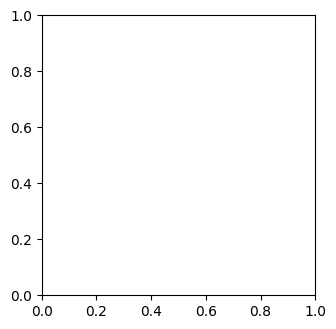

In [38]:
# Graficar las distribuciones posteriores de los parámetros
plt.figure(figsize=(12, 8))
param_names = ['beta', 'gamma', 'eta', 'mu', 'theta']
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.hist(accepted_params[:, i], bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribución de {param_names[i]}')
plt.tight_layout()
plt.show()

# Validación del modelo
best_params = accepted_params[-1]  # Usar los últimos parámetros aceptados
predicted = sim_modelo(best_params, S0, E0, I0, R0, N, time)

# Truncar las predicciones a 52 semanas
predicted_weekly = predicted[:364].reshape(-1, 7).sum(axis=1)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(influenza_data, 'ro', label='Datos observados de influenza')
plt.plot(predicted_weekly, 'b-', label='Predicciones del modelo')
plt.xlabel('Semanas')
plt.ylabel('Casos de influenza')
plt.legend()
plt.show()

# Calcular el Error Cuadrático Medio (MSE)
mse = np.mean((influenza_data - predicted_weekly)**2)
print(f'MSE: {mse}')

# Calcular el Coeficiente de Determinación (R²)
def r_squared(observed, predicted):
    mean_observed = np.mean(observed)
    ss_total = np.sum((observed - mean_observed)**2)
    ss_residual = np.sum((observed - predicted)**2)
    return 1 - (ss_residual / ss_total)

r2 = r_squared(influenza_data, predicted_weekly)
print(f'R²: {r2}')